In [1]:
import os
import sys

src_dir = './../src/'
sys.path[0] = src_dir

import matplotlib.pyplot as plt

import glob

import numpy as np
import pandas as pd
import seaborn as sns

from access_biology_data import meta, relations, properties
from access_literature_data import medline
from access_science_shared import standardizer 

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [3]:
sys.path.append('./../src/')
from aging_tools import inout, export
from access_aging_data import companions

In [4]:
from natsort import natsorted
from scipy.stats import spearmanr
from access_biology_data import relations

In [5]:
from scipy.stats import wilcoxon

In [6]:
outfolder = '220308_human_imbalance_for_conserved_genes'

In [7]:
save_images = False

In [8]:
ref_genes = standardizer.reference_genes(9606, 'orp')

/Users/tstoeger/opt/miniconda3/envs/aging/lib/python3.7/site-packages/fastparquet/dataframe.py:5: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import CategoricalIndex, RangeIndex, Index, MultiIndex


In [9]:
all_de = companions.tstoeger_190427_gtex()

In [10]:
all_de = all_de[
    (all_de['padj'].notnull()) &
    (all_de['gene_ncbi'].isin(ref_genes))
]

In [11]:
f = (all_de['younger'].isin([2, 3])) & (all_de['older'].isin([6, 7]))
all_de = all_de.loc[f, :].copy()

In [12]:
all_de.loc[:, 'reduced_tissue'] = all_de['tissue'].str.replace(
    ' - ', '_').str.replace(' ', '_').str.replace(
    '-', '_').str.replace('(','').str.replace(')', '')

all_de.loc[:, 'condition'] = all_de.loc[:, 'gender'] + 's_' + all_de['reduced_tissue'] + '_' + \
    all_de['older'].astype(int).astype(str) + '_vs_' + all_de['younger'].astype(int).astype(str)

conditions = natsorted(all_de['condition'].unique())

In [13]:
pr = properties.genbank_validated_rna(9606)[['gene_ncbi', 'Genbank_validated_RNA: full_SumACGT']].rename(columns={
    'Genbank_validated_RNA: full_SumACGT': 'length'
})

pr.loc[:, 'log_length'] = np.log10(pr['length'])

In [14]:
hg = relations.homologene()

ho = pd.merge(
    hg[hg['taxon_ncbi']==9606][['homologene_group', 'gene_ncbi']],
    hg[hg['taxon_ncbi']==559292][['homologene_group', 'gene_ncbi']],
    on='homologene_group',
    suffixes=('_h', '_y')
).drop_duplicates()

In [15]:
ho['gene_ncbi_h'].unique()

array([       38,       158,       210, ..., 100529261,      6576,
          375346])

In [16]:
ho.shape

(1359, 3)

In [17]:
path_to_data = inout.get_internal_path(
    (
        'datasets/general/resources/publications/'
        'hu_2014/Supplemental_Table_1.xls'
    )
)

df_hu = pd.read_excel(
    path_to_data,
    sheet_name='young vs old'
)

taxon_id = 559292
g = meta.gene_info(taxon_id)

In [18]:
m = pd.merge(
    g[['gene_ncbi', 'LocusTag']].rename(columns={'LocusTag': 'gene'}), 
    df_hu)

In [19]:
highly_responsive  = ho[ho['gene_ncbi_y'].isin(
    m[
        (m['logFC']>0) &
        (m['FDR']<0.05)
    ]['gene_ncbi']
)]['gene_ncbi_h'].unique()

In [20]:
#Genes to consider
ho_in_m = ho[ho['gene_ncbi_y'].isin(m['gene_ncbi'])]
all_de = all_de[all_de['gene_ncbi'].isin(ref_genes)]
# all_de = all_de[all_de['gene_ncbi'].isin(ho['gene_ncbi_h'])]

In [21]:
out = pd.DataFrame(index=conditions, columns=[
     'corr_conserved', 'corr_non_conserved', 'corr_high', 'corr_non_high'
]).rename_axis('condition')

In [22]:
for condition in conditions:
    d = all_de[
        all_de['condition']==condition
    ]

    d = d[['gene_ncbi', 'o_over_y']].dropna()
    d = pd.merge(d, pr)
    
    
    f  = d['gene_ncbi'].isin(ho['gene_ncbi_h'])
    r, p = spearmanr(d.loc[f, 'log_length'], d.loc[f, 'o_over_y'])
    out.loc[condition, 'corr_conserved'] = r
    
    r, p = spearmanr(d.loc[~f, 'log_length'], d.loc[~f, 'o_over_y'])
    out.loc[condition, 'corr_non_conserved'] = r
    
    
    d = d[d['gene_ncbi'].isin(ho_in_m['gene_ncbi_h'])].copy()

    f  = d['gene_ncbi'].isin(highly_responsive)
    r, p = spearmanr(d.loc[f, 'log_length'], d.loc[f, 'o_over_y'])
    out.loc[condition, 'corr_high'] = r
    
    r, p = spearmanr(d.loc[~f, 'log_length'], d.loc[~f, 'o_over_y'])
    out.loc[condition, 'corr_non_high'] = r

In [23]:
out = out.reset_index()

In [24]:
mega = pd.merge(out, all_de[['condition', 'gender', 'tissue', 'younger', 'older']].drop_duplicates())

In [25]:
mega['corr_conserved'] = mega['corr_conserved'].astype(float)
mega['corr_non_conserved'] = mega['corr_non_conserved'].astype(float)

In [26]:
mega['corr_high'] = mega['corr_high'].astype(float)
mega['corr_non_high'] = mega['corr_non_high'].astype(float)

In [27]:
m = mega.groupby(
    ['gender', 'tissue']
)[['corr_high', 'corr_non_high', 'corr_conserved', 'corr_non_conserved']].median().reset_index()

In [28]:
x = 'corr_non_conserved'
y = 'corr_conserved'

In [29]:
spearmanr(m[x], m[y])

SpearmanrResult(correlation=0.8979385820085852, pvalue=1.1068628079711384e-31)

Text(0, 0.5, 'corr_conserved')

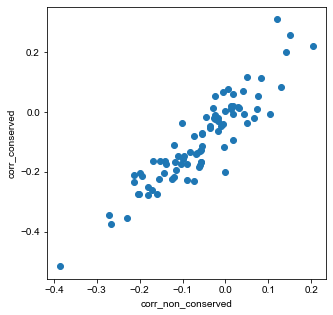

In [30]:
plt.figure(figsize=(5, 5))
plt.scatter(m[x], m[y])
# plt.xlim([-0.6, 0.4])
# plt.ylim([-0.6, 0.4])
plt.xlabel(x)
plt.ylabel(y)

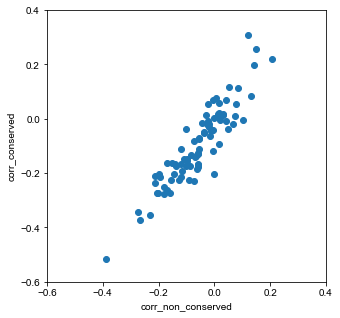

In [31]:
plt.figure(figsize=(5, 5))
plt.scatter(m[x], m[y])
plt.xlim([-0.6, 0.4])
plt.ylim([-0.6, 0.4])
plt.xlabel(x)
plt.ylabel(y)

if save_images:
    export.export_image(
        '{}/comparison_conserved.pdf'.format(outfolder))

In [32]:
m.shape[0]

86

In [33]:
(m[y] > m[x]).mean()

0.2558139534883721

In [34]:
wilcoxon(m[x], m[y])

WilcoxonResult(statistic=719.0, pvalue=7.109239279108243e-07)

In [35]:
x = 'corr_non_high'
y = 'corr_high'

In [36]:
spearmanr(m[x], m[y])

SpearmanrResult(correlation=0.8451436388508892, pvalue=1.444998059049458e-24)

Text(0, 0.5, 'corr_high')

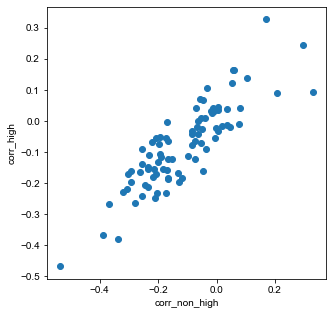

In [37]:
plt.figure(figsize=(5, 5))
plt.scatter(m[x], m[y])
# plt.xlim([-0.6, 0.4])
# plt.ylim([-0.6, 0.4])
plt.xlabel(x)
plt.ylabel(y)


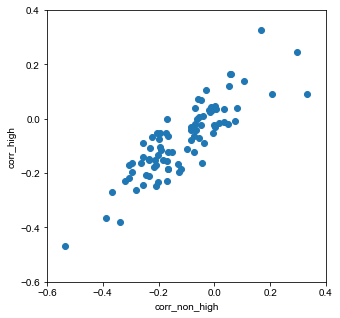

In [38]:
plt.figure(figsize=(5, 5))
plt.scatter(m[x], m[y])
plt.xlim([-0.6, 0.4])
plt.ylim([-0.6, 0.4])
plt.xlabel(x)
plt.ylabel(y)

if save_images:
    export.export_image(
        '{}/comparison_high_up.pdf'.format(outfolder))

In [39]:
m.shape[0]

86

In [40]:
(m[y] > m[x]).mean()

0.7093023255813954

In [41]:
wilcoxon(m[x], m[y])

WilcoxonResult(statistic=889.0, pvalue=2.3752723912642547e-05)